# Communication statistics study
In this document we will build a model to predict audience for articles published in a company internal magazine.
Raw data have been extracted in html form from the company intranet. Articles arepublished on 3 web media :
1. L'Accent, which is the official internal magazine
2. L'Accent Manager, which is a subside from the previous one, but only for the company executives
3. On Air, which is also a susbide from L'Accent but only with videos and audios

For each of these media we have the title of the articles, its teaser in a few lines, its publishing date, its theme, sometimes its sub theme and finally the numbers of views, and the number of likes which we will try to predict.

Resume:
After extracting the data from raw html documents, we'll build visualizations which shows that any model using only the theme of an article to predict its audience will produce unsufficient results since the distribution of views for a given theme is widely spread. This conclusion will lead us to a model taking into account the words in the title of each articles using the bag of words technique. We'll then see if another clustering of the articles based on the bag of words could be a better predictor of its final views than the theme.

## Creating a proper csv from an html document

## Building a data model
We first aim at creating 3 pandas dataframe to perform analysis. These dataframe shall have the following form:
- Laccent articles : ['DATE', 'TITRE', 'RESUME', 'THEME', 'SOUS_THEME', 'LIKES', 'VUES']
- onair articles : ['DATE', 'THEME', 'SOUS_THEME', 'TITRE', 'DUREE', 'VUES']
- Laccent manager articles : ['DATE', 'TITRE', 'RESUME', 'THEME', 'SOUS_THEME', 'LIKES', 'VUES']

For that we import the proper Python libraries for dataframe creation and to attribute the proper data type to each column. We import matplotlib pyplot for Dataviz.

In [2]:
#Libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
#CSV document import
Laccent=pd.read_csv("/home/reddowan/Documents/AirFrance/Laccent_extract.csv", sep=";")
onair=pd.read_csv("/home/reddowan/Documents/AirFrance/onair_extract.csv", sep=";")

#We print the dataframe columns for verification
print(list(Laccent.columns.values))
print(list(onair.columns.values))

['DATE', 'TITRE', 'RESUME', 'THEME', 'SOUS_THEME', 'LIKES', 'VUES', 'Unnamed: 7']
['DATE', 'THEME', 'SOUS_THEME', 'TITRE', 'DUREE', 'VUES', 'Unnamed: 6']


In [4]:
#An Unnamed column has been created in both cases, there may be errors in the csv files, we checking these columns to see if they contain any data
Laccent['Unnamed: 7'].index[Laccent['Unnamed: 7'].apply(np.isnan)]
onair['Unnamed: 6'].index[onair['Unnamed: 6'].apply(np.isnan)]

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            548, 549, 550, 551, 552, 553, 554, 555, 556, 557],
           dtype='int64', length=558)

In [5]:
#They do not contain data so we get rid of these unnamed columns
Laccent=pd.DataFrame(Laccent, columns=['DATE','TITRE','RESUME','THEME','SOUS_THEME','LIKES','VUES'])
onair=pd.DataFrame(onair, columns=['DATE','TITRE','THEME','SOUS_THEME','DUREE','VUES'])

In [6]:
#Converting Laccent column DATE from string to datetime and VUES to int, in order to have the proper datatypes
for index,row in Laccent.iterrows():
    Laccent['DATE'][index]=datetime.datetime.strptime(Laccent['DATE'][index], "%d.%m.%Y").date()
    Laccent['VUES'][index]=int(Laccent['VUES'][index])

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
#Converting onair column DATE from string to datetime and VUES to int and DUREE to datetime, in order to have the proper datatypes
for index,row in onair.iterrows():
    onair['DATE'][index]=datetime.datetime.strptime(onair['DATE'][index], "%d.%m.%Y").date()
    #print(index,onair['TITRE'][index])
    onair['VUES'][index]=int(onair['VUES'][index])
    #onair['DUREE'][index]=datetime.datetime.strptime(onair['DUREE'][index], "%M:%S").date()

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#Let's print the 10 most read articles in the magazine Laccent for verification
Laccent.sort(['VUES'], ascending=0).head(10)

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,DATE,TITRE,RESUME,THEME,SOUS_THEME,LIKES,VUES
241,2015-12-07,Jeu concours : faites le tour de France en 747 !,Le jeu-concours est terminé ! Voici la liste d...,TALENTS ET METIERS,FLOTTE,117,25340
249,2015-12-03,AF747 : un vol en hommage au Super Jumbo,"Le 14 janvier 2016 prochain, Air France organi...",FLOTTE,CLIENT,72,11254
171,2016-02-03,Deux fleurons aéronautiques se donnent rendez-...,"Le 27 janvier 2016, au-dessus de la Camargue, ...",TALENTS ET METIERS,FLOTTE,143,10186
207,2016-01-11,Adieux au 747,"Le 11 janvier 2016 à 14h, le dernier vol comme...",FLOTTE,TALENTS ET METIERS,112,9549
35,2016-06-01,Profitez d'une offre wifi internationale réser...,Vous souhaitez rester connecté durant vos séjo...,COMMUNICATION,TALENTS ET METIERS,24,8466
223,2015-12-17,Second vol en hommage au 747 d'Air France,Air France a reçu près de 30 000 appels en 24 ...,CLIENT,FLOTTE,29,7772
165,2016-02-09,"Participez à l'opération ""Femmes d'Air France ...",A l'occasion de la Journée internationale des ...,TALENTS ET METIERS,NaN,49,5909
57,2016-05-12,Les Cars Air France deviennent Le Bus Direct,"A compter du 12 mai 2016, Kéolis, actionnaire ...",PRODUITS ET SERVICES,CLIENT,0,5697
258,2015-11-24,Téléchargez la nouvelle application L'accent,Découvrez en exclusivité la toute nouvelle app...,COMMUNICATION,COMMUNICATION,21,5561
178,2016-01-29,La Patrouille de France salue le 747 !,"Le 27 janvier au dessus de la Camargue, douze ...",TALENTS ET METIERS,FLOTTE,112,5461


In [9]:
#Let's print also the 10 most seen onair contents
onair.sort(['VUES'], ascending=0).head(10)

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,DATE,TITRE,THEME,SOUS_THEME,DUREE,VUES
240,2015-03-16,Démonstrations de sécurité,GROUPE ET COMPAGNIE,07 - Sécurité des vols,04:40,25546
245,2015-03-04,Nouveau film publicitaire,GROUPE ET COMPAGNIE,06 - Communication,01:00,24732
75,2016-02-01,Rendez-vous de 2 fleurons aéronautiques,GROUPE ET COMPAGNIE,12 - Evénement,03:30,12658
313,2014-09-19,Message aux pilotes,GROUPE ET COMPAGNIE,01 - Stratégie,4:13,12548
150,2015-09-08,Interview de Frédéric Gagey,GROUPE ET COMPAGNIE,14 - Perform 2020,05:11,12454
191,2015-06-16,Mesures d'adaptation : ITW de F.Gagey,GROUPE ET COMPAGNIE,14 - Perform 2020,05:09,11491
315,2014-09-04,"Ebola, le point de vue du CDC",GROUPE ET COMPAGNIE,01 - Stratégie,07:52,11443
365,2014-05-06,... la nouvelle suite La Première,PRODUITS ET CLIENTS,Tout savoir sur...,00:44,11423
339,2014-06-18,Making of nouvelles cabines,PRODUITS ET CLIENTS,Les making of,01:16,10490
257,2015-01-29,Tous ensemble pour retrouver notre place,GROUPE ET COMPAGNIE,14 - Perform 2020,06:21,10155


## Creating our first dataviz
Our aim is to identify clear visible pattern in the data (if there is any). So to start we would like to see the following viz :
1. Article number of views distribution (what's the typical number of views for an article? what range?)
2. Number of views per article per publishing date (is the number of views per article globally rising?declining? does the date of the article have an influence on its audience?)
3. What are the most read article theme by the audience?
4. Finaly,is there a clear correlation the theme and the distribution of the number of views?

These quetions are essential as they aim at finding what truly interest our readers and if the content is appropriate to what the audience is seeking. Finding the answer to these questions is also key to building our audience predictor, if the theme has no clear influence on views it means that the reader is clicking (or not) on the article basing its judgment of interest on something else which is probably the words of the article title.

La moyenne de vue par article Laccent est de 1376.1528239202657 
la mediane de vue des articles Laccent est de 868.0 
et la deviation standard des articles Laccent est de 2047.0648406180696


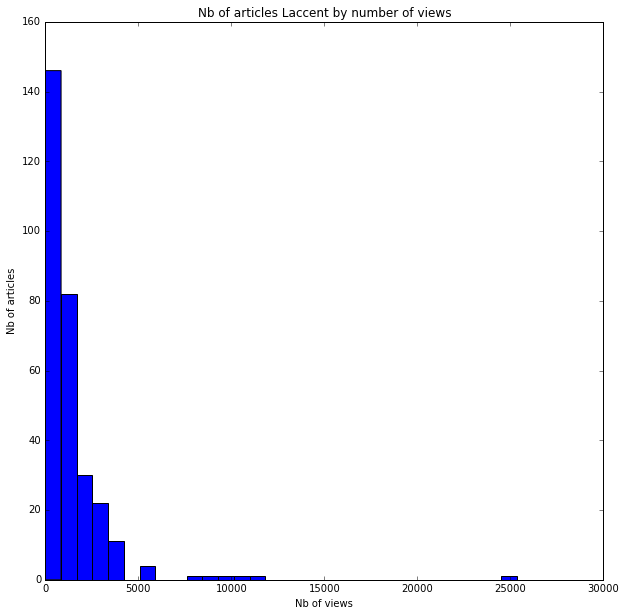

In [10]:
%matplotlib inline

print("La moyenne de vue par article Laccent est de", np.mean(Laccent['VUES']),
      "\nla mediane de vue des articles Laccent est de",np.median(Laccent['VUES']),
      "\net la deviation standard des articles Laccent est de",np.std(Laccent['VUES']))
plt.figure(figsize=(10,10))
plt.title('Nb of articles Laccent by number of views')
plt.xlabel('Nb of views')
plt.ylabel('Nb of articles')
plt.hist(Laccent['VUES'],bins=30)
plt.show()

The result here are interesting because we realize that halfthe articles does not pass 868 number of views which is quite low for a potential audience of 47k people inside the company. We can also see that a few articles have outstanding number of views surpassing 5x to 10x the average.

La moyenne de vue par article onair est de 1871.7293906810037 
la mediane des articles onair est de 1148.0 
et la deviation standard des articles onair est de 2585.476741787897


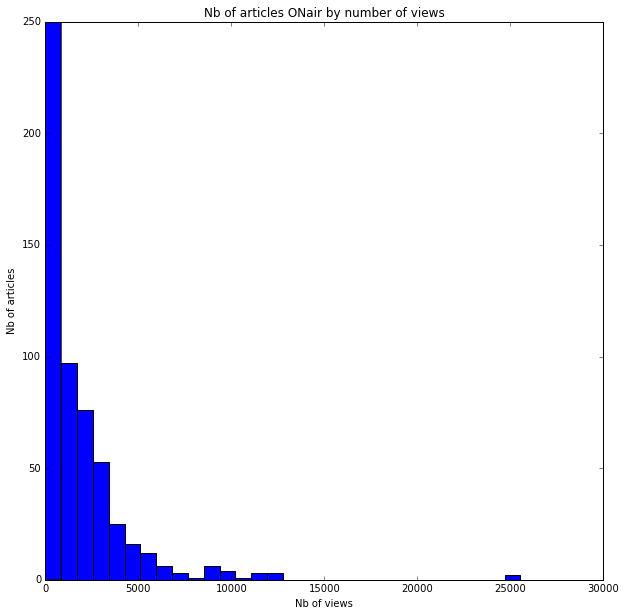

In [11]:
print("La moyenne de vue par article onair est de", np.mean(onair['VUES']),
      "\nla mediane des articles onair est de",(onair['VUES'].median()),
      "\net la deviation standard des articles onair est de",np.std(onair['VUES']))
plt.figure(figsize=(10,10))
plt.title('Nb of articles ONair by number of views')
plt.xlabel('Nb of views')
plt.ylabel('Nb of articles')
plt.hist(onair['VUES'],bins=30)
#plt.hist(onair['VUES'])
plt.show()

The same observation are true for onair contents.

In [12]:
#list_titre=pd.concat([Laccent['TITRE'],onair['TITRE']],ignore_index=True)
#print(list_titre)

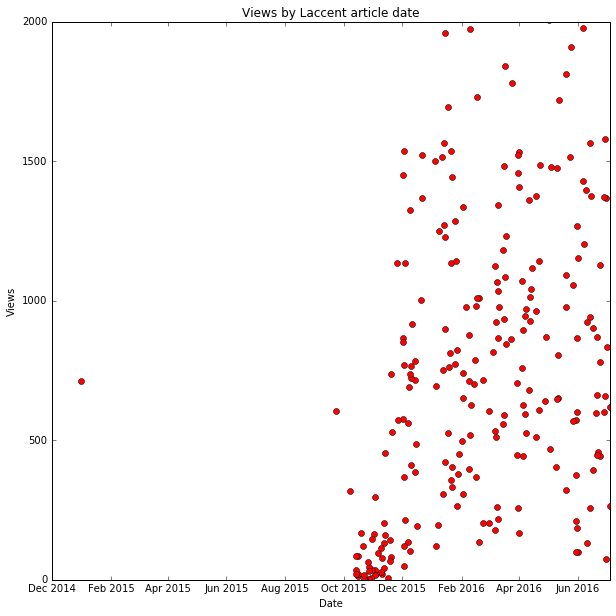

In [13]:
x=Laccent['DATE']
y=Laccent['VUES']
plt.figure(figsize=(10,10))
plt.title('Views by Laccent article date')
plt.xlim(xmin=datetime.datetime.strptime("01.12.2014", "%d.%m.%Y").date(),xmax=datetime.datetime.strptime("04.07.2016", "%d.%m.%Y").date())
plt.ylim(ymin=0,ymax=2000)
plt.xlabel('Date')
plt.ylabel('Views')
plt.plot(x,y,'ro')
plt.show()

This viz is also very interesting, we can see that there must be something missing in the data for the year 2015 for Laccent articles. The web magazine has been put online in the beginning of 2015 and apparently data has been lost. The articles published at the end of 2015 also all have a very low number of views which can only be explained by missing data.
Data in 2016 seem complete and there is no clear pattern of a evolution in the global number of views.

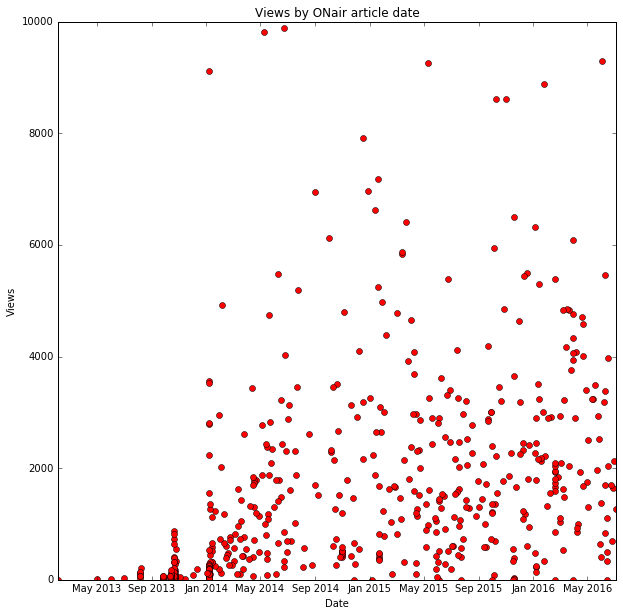

In [14]:
x=onair['DATE']
y=onair['VUES']
plt.figure(figsize=(10,10))
plt.title('Views by ONair article date')
plt.ylim(ymin=0,ymax=10000)
plt.xlabel('Date')
plt.ylabel('Views')
plt.plot(x,y,'ro')
plt.show()

ONair data seem more complete over the time period 2014-2016 as no missing data pattern is apparent on this visualization. We can see that the missing data are probably over the 2013 period where the audience and the number of articles seem oddly low.

In [15]:
#We list the different themes that we have in the dataframe Laccent in an array to perform an analysis by theme.
list_theme_Laccent=pd.concat([Laccent['THEME'],Laccent['SOUS_THEME']],ignore_index=True).unique()

In [16]:
#We list the different theme the same way for ONair but the structure is not the same, there is three differents main themes and a lot of subthemes
print(onair['THEME'].unique())
list_theme_onair=pd.concat([onair['THEME'],onair['SOUS_THEME']],ignore_index=True).unique()

['GROUPE ET COMPAGNIE' 'PRODUITS ET CLIENTS' 'MANAGER']


In [17]:
#Let's analyse some statistics for Laccent by theme likethe total number of articles, views, and a mean
resume_Laccent=pd.DataFrame({'THEME':np.zeros(34),'SUM':np.zeros(34),'COUNT':np.zeros(34),'MEAN':np.zeros(34)})

for index,row in resume_Laccent.iterrows():
    resume_Laccent['THEME'][index]=list_theme_Laccent[index]
    resume_Laccent['SUM'][index]=Laccent[Laccent.THEME==list_theme_Laccent[index]]['VUES'].sum()+Laccent[Laccent.SOUS_THEME==list_theme_Laccent[index]]['VUES'].sum()
    resume_Laccent['COUNT'][index]=Laccent[Laccent.THEME==list_theme_Laccent[index]]['VUES'].count()+Laccent[Laccent.SOUS_THEME==list_theme_Laccent[index]]['VUES'].count()
    resume_Laccent['MEAN'][index]=resume_Laccent['SUM'][index]/resume_Laccent['COUNT'][index]

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to 

In [18]:
#Same thing for ONair 
resume_onair=pd.DataFrame({'THEME':np.zeros(34),'SUM':np.zeros(34),'COUNT':np.zeros(34),'MEAN':np.zeros(34)})

for index,row in resume_onair.iterrows():
    resume_onair['THEME'][index]=list_theme_onair[index]
    resume_onair['SUM'][index]=onair[onair.THEME==list_theme_onair[index]]['VUES'].sum()+onair[onair.SOUS_THEME==list_theme_onair[index]]['VUES'].sum()
    resume_onair['COUNT'][index]=onair[onair.THEME==list_theme_onair[index]]['VUES'].count()+onair[onair.SOUS_THEME==list_theme_onair[index]]['VUES'].count()
    resume_onair['MEAN'][index]=resume_onair['SUM'][index]/resume_onair['COUNT'][index]

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to 

In [19]:
#Let's see the 10 most viewed theme on L'accent (filter on theme with more than 5 articles to be representative)
resume_Laccent[resume_Laccent.COUNT>5].sort(['MEAN'], ascending=0).head(10)

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,COUNT,MEAN,SUM,THEME
14,27.0,3464.333333,93537.0,FLOTTE
1,77.0,1784.350649,137395.0,TALENTS ET METIERS
20,9.0,1502.333333,13521.0,TRANSAVIA
8,14.0,1483.714286,20772.0,PRODUITS ET SERVICES
0,102.0,1369.117647,139650.0,CLIENT
3,86.0,1364.953488,117386.0,STRATEGIE
10,30.0,1349.733333,40492.0,COMMUNICATION
13,38.0,1209.710526,45969.0,PASSAGE
6,12.0,1056.250000,12675.0,PRIX ET RECOMPENSES
15,11.0,1029.636364,11326.0,HOP! AIR FRANCE


In [20]:
#Let's see the 10 less viewed theme on L'accent (filter on theme with more than 5 articles to be representative)
resume_Laccent[resume_Laccent.COUNT>5].sort(['MEAN'], ascending=1).head(10)

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,COUNT,MEAN,SUM,THEME
21,8.0,370.250000,2962.0,FONDATION AIR FRANCE
9,12.0,670.083333,8041.0,DEVELOPPEMENT DURABLE
4,6.0,772.166667,4633.0,SECURITE DES VOLS
5,10.0,813.600000,8136.0,PARTENARIATS
30,6.0,934.000000,5604.0,RESSOURCES HUMAINES
7,13.0,947.307692,12315.0,PERFORM 2020
17,11.0,1010.090909,11111.0,BEST AND BEYOND
11,18.0,1011.611111,18209.0,GROUPE
15,11.0,1029.636364,11326.0,HOP! AIR FRANCE
6,12.0,1056.250000,12675.0,PRIX ET RECOMPENSES


In [21]:
#Let's see the 10 most viewed theme on ONair (filter on theme with more than 5 articles to be representative)
resume_onair[resume_onair.COUNT>5].sort(['MEAN'], ascending=0).head(10)

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,COUNT,MEAN,SUM,THEME
25,6.0,10142.833333,60857.0,14 - Perform 2020
17,9.0,3400.444444,30604.0,03 - Les décodeurs
29,7.0,3362.000000,23534.0,Les making of
12,69.0,3055.173913,210807.0,06 - Communication
7,15.0,3029.866667,45448.0,07 - Sécurité des vols
3,40.0,2831.975000,113279.0,01 - Stratégie
23,9.0,2788.666667,25098.0,04 - La boîte à questions
16,53.0,2759.716981,146265.0,12 - Evénement
0,318.0,2386.201258,758812.0,GROUPE ET COMPAGNIE
24,20.0,1922.700000,38454.0,Tout savoir sur...


In [22]:
#Let's see the 10 less viewed theme on ONair (filter on theme with more than 5 articles to be representative)
resume_onair[resume_onair.COUNT>5].sort(['MEAN'], ascending=1).head(10)

/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,COUNT,MEAN,SUM,THEME
32,13.0,243.307692,3163.0,Offre Industrie
10,12.0,552.083333,6625.0,Au sol
20,11.0,759.454545,8354.0,A table
33,20.0,780.650000,15613.0,02 - La Radio
27,9.0,815.111111,7336.0,05 - Zoom sur...
31,7.0,885.714286,6200.0,Offre Cargo
18,34.0,910.970588,30973.0,11 - La Saga
30,17.0,917.411765,15596.0,06 - Parlons-En !
11,19.0,925.315789,17581.0,10 - Engagement
9,15.0,973.333333,14600.0,01 - Enjeux et stratégie


These results are very interesting because they show different topics being mostly viewed by the public which has an explanation because the two medias have been used for different purposes.
On L'accent, the most viewed theme corredpond to the arrival of new aircrafts, new products and services, customer and strategy arrives close.
On ONair strategy is all over the winning places with Perform videos, the decodeurs which are pedagogic videos on strategy and again strategy.
One might think that this has to be put in perspective of the relative number of content published. The following viz shows that compared to other content published at the samedate, strategy/economy related contents are clearly preferred by the viewers.

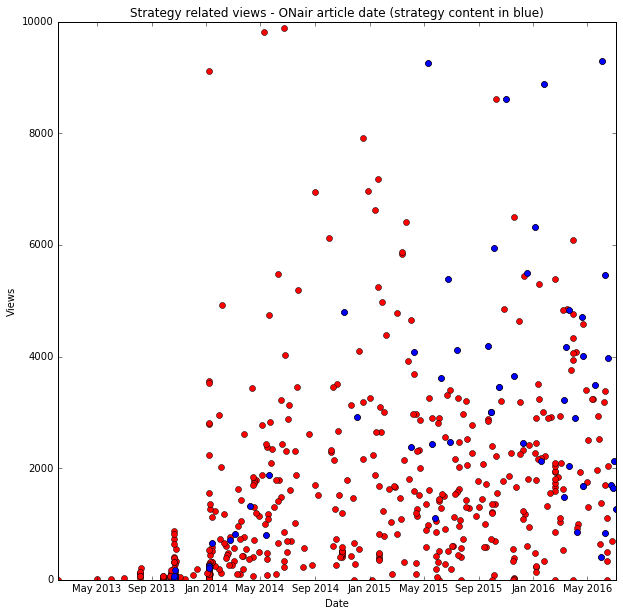

In [23]:
x1=onair['DATE']
y1=onair['VUES']

x2=onair[onair.SOUS_THEME=='14 - Perform 2020']['DATE']
y2=onair[onair.SOUS_THEME=='14 - Perform 2020']['VUES']

x3=onair[onair.SOUS_THEME=='03 - Les décodeurs']['DATE']
y3=onair[onair.SOUS_THEME=='03 - Les décodeurs']['VUES']

x4=onair[onair.SOUS_THEME=='01 - Stratégie']['DATE']
y4=onair[onair.SOUS_THEME=='01 - Stratégie']['VUES']

x5=onair[onair.SOUS_THEME=='15 - Les décodeurs']['DATE']
y5=onair[onair.SOUS_THEME=='15 - Les décodeurs']['VUES']

x6=onair[onair.SOUS_THEME=='15 - Les décodeurs']['DATE']
y6=onair[onair.SOUS_THEME=='15 - Les décodeurs']['VUES']

x7=onair[onair.SOUS_THEME=="02 - L'éco sur un plateau"]['DATE']
y7=onair[onair.SOUS_THEME=="02 - L'éco sur un plateau"]['VUES']

x8=onair[onair.SOUS_THEME=="17- L'éco sur un plateau"]['DATE']
y8=onair[onair.SOUS_THEME=="17- L'éco sur un plateau"]['VUES']

plt.figure(figsize=(10,10))
plt.title('Strategy related views - ONair article date (strategy content in blue)')
plt.ylim(ymin=0,ymax=10000)
plt.xlabel('Date')
plt.ylabel('Views')
plt.plot(x1,y1,'ro')
plt.plot(x2,y2,'ro',color='blue')
plt.plot(x3,y3,'ro',color='blue')
plt.plot(x4,y4,'ro',color='blue')
plt.plot(x5,y5,'ro',color='blue')
plt.plot(x6,y6,'ro',color='blue')
plt.plot(x7,y7,'ro',color='blue')
plt.plot(x8,y8,'ro',color='blue')

plt.show()

In [24]:
#The seaborn python librarie will allow us to better visualize the distribution of the article views by theme
import seaborn as sns

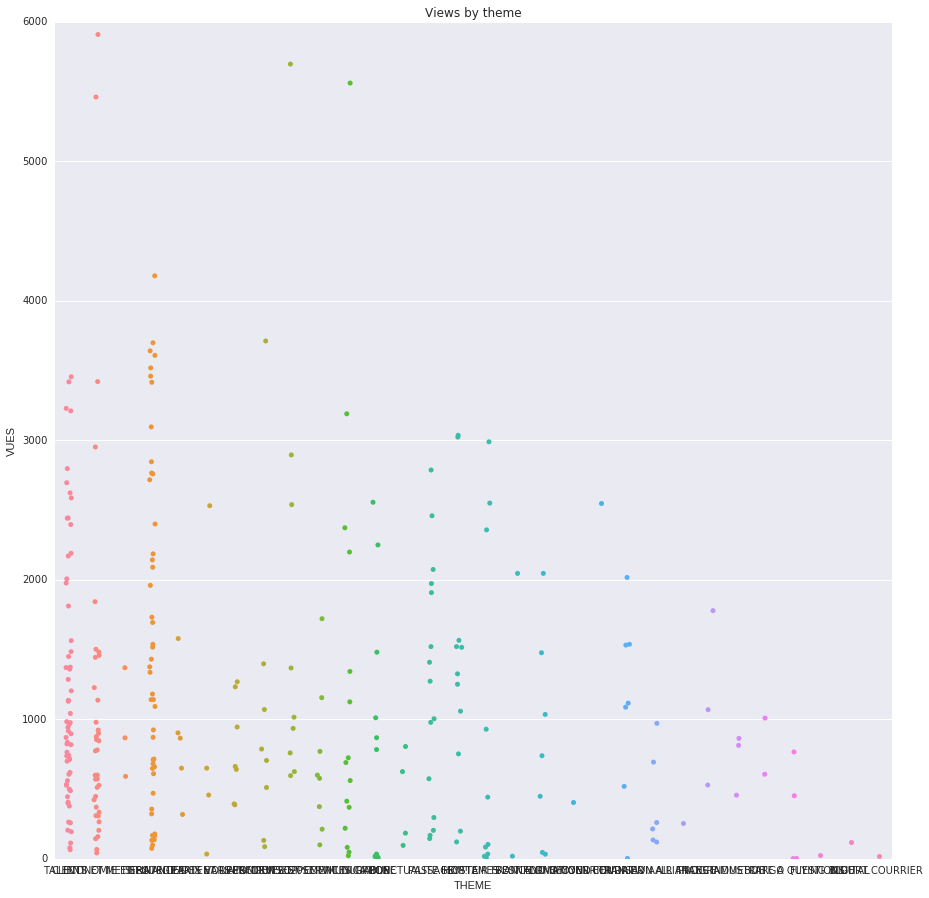

In [25]:
#Lets visualize Laccent number of views by the main theme to see if there is a clear pattern
plt.figure(figsize=(15,15))
plt.ylim(ymin=0,ymax=6000)
plt.title('Views by theme')
sns.stripplot(x=Laccent['THEME'], y=Laccent['VUES'], data=Laccent, jitter=True);

Visualizing a clear trend in Laccent article is a more difficult. It is less obvious to see if a few good articles are responsible for the good statistics or if they rely on a clear public preference.

In [26]:
#We will visualize the influence of the day and the week on the total numbers of views, for that we create new columns in the data
onair.insert(loc=1,column='WEEK',value=0)
onair.insert(loc=1,column='SUNDAY',value=0)
onair.insert(loc=1,column='SATURDAY',value=0)
onair.insert(loc=1,column='FRIDAY',value=0)
onair.insert(loc=1,column='THURSDAY',value=0)
onair.insert(loc=1,column='WEDNESDAY',value=0)
onair.insert(loc=1,column='TUESDAY',value=0)
onair.insert(loc=1,column='MONDAY',value=0)

In [27]:
#We fill the columns with the number of the week and to what day in the week it is  
for index,row in onair.iterrows():
    onair['WEEK'][index]=onair['DATE'][index].toordinal()//7
    jour=onair['DATE'][index].isoweekday()
    if jour==1:
        onair['MONDAY'][index]=1
    elif jour==2:
        onair['TUESDAY'][index]=1
    elif jour==3:
        onair['WEDNESDAY'][index]=1
    elif jour==4:
        onair['THURSDAY'][index]=1
    elif jour==5:
        onair['FRIDAY'][index]=1
    elif jour==6:
        onair['SATURDAY'][index]=1
    elif jour==7:
        onair['SUNDAY'][index]=1


/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWa

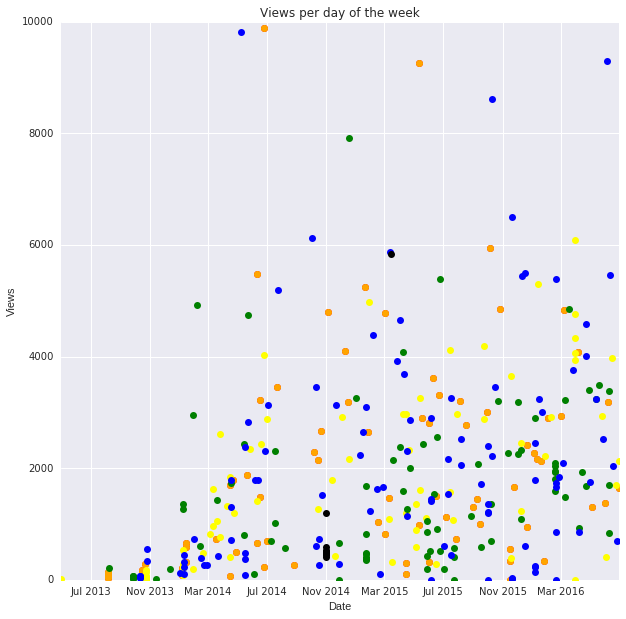

In [28]:
#Visualize the data per week et per day of the week
x1=onair[onair.MONDAY==1]['DATE']
y1=onair[onair.MONDAY==1]['VUES']

x2=onair[onair.TUESDAY==1]['DATE']
y2=onair[onair.TUESDAY==1]['VUES']

x3=onair[onair.WEDNESDAY==1]['DATE']
y3=onair[onair.WEDNESDAY==1]['VUES']

x4=onair[onair.THURSDAY==1]['DATE']
y4=onair[onair.THURSDAY==1]['VUES']

x5=onair[onair.FRIDAY==1]['DATE']
y5=onair[onair.FRIDAY==1]['VUES']

x6=onair[onair.SATURDAY==1]['DATE']
y6=onair[onair.SATURDAY==1]['VUES']

x7=onair[onair.SUNDAY==1]['DATE']
y7=onair[onair.SUNDAY==1]['VUES']


plt.figure(figsize=(10,10))
plt.title('Views per day of the week')
plt.ylim(ymin=0,ymax=10000)
plt.xlabel('Date')
plt.ylabel('Views')
plt.plot(x2,y2,'ro',color='red')
plt.plot(x2,y2,'ro',color='orange')
plt.plot(x3,y3,'ro',color='yellow')
plt.plot(x4,y4,'ro',color='green')
plt.plot(x5,y5,'ro',color='blue')
plt.plot(x6,y6,'ro',color='black')
plt.plot(x7,y7,'ro',color='black')

plt.show()

In [29]:
#Getting a few statistics per day of the week
print("la mediane de vue des articles onair vus le lundi est",y1.median(),"pour",y1.count(),"articles")
print("la mediane de vue des articles onair vus le mardi est",y2.median(),"pour",y2.count(),"articles")
print("la mediane de vue des articles onair vus le mercredi est",y3.median(),"pour",y3.count(),"articles")
print("la mediane de vue des articles onair vus le jeudi est",y4.median(),"pour",y4.count(),"articles")
print("la mediane de vue des articles onair vus le vendredi est",y5.median(),"pour",y5.count(),"articles")
print("la mediane de vue des articles onair vus le samedi est",y6.median(),"pour",y6.count(),"articles")
print("la mediane de vue des articles onair vus le dimanche est",y7.median(),"pour",y7.count(),"articles")

la mediane de vue des articles onair vus le lundi est 831.5 pour 164 articles
la mediane de vue des articles onair vus le mardi est 1007.0 pour 101 articles
la mediane de vue des articles onair vus le mercredi est 1201.0 pour 87 articles
la mediane de vue des articles onair vus le jeudi est 1361.0 pour 91 articles
la mediane de vue des articles onair vus le vendredi est 1720.0 pour 105 articles
la mediane de vue des articles onair vus le samedi est 509.0 pour 9 articles
la mediane de vue des articles onair vus le dimanche est 5832.0 pour 1 articles


## Challenge the theme classification using the bag of words clustering
We've seen that the theme classification wasn't a clear discriminant for the audience in Laccent views analysis. On the ONair video/audio content it seems clearer. But what the users see when he reaches the welcome page on thecompany intranet is not the category of any given article, its his title and sometimes its teaser, that is what leads the viewer to click or not on the article. Acknowledging this fact we will try another view on the articles using a bag of words clustering to determine if certain words are responsible for maximizing the views and to what topic or related articles they are linked.

In [30]:
#Importing librairies to stem resume and titles of articles
import re
from nltk.stem.snowball import FrenchStemmer
stemmer=FrenchStemmer()
for index in range(len(Laccent['RESUME'])):
    article=""
    titre=""
    for word in re.split("\W+",Laccent['RESUME'][index]):
        article=article+stemmer.stem(word)+" "
    for word in re.split("\W+",Laccent['TITRE'][index]):
        titre=titre+stemmer.stem(word)+" "
    Laccent['TITRE'][index]=titre


/home/reddowan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
#Importing stopwords for french language
from stop_words import get_stop_words

stop_words = get_stop_words('fr')
#importing vectorizer to create a sparse matrix of all words token in Laccent.First step to words clustering (filter stopwords)
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words=stop_words)
Resume_token = count_vect.fit_transform(Laccent['RESUME']+" "+Laccent['TITRE'])
Resume_token.shape

(301, 3063)

In [32]:
#Verifying that the stopwordshave been removed
print(count_vect.vocabulary_.get(u'est'))

None


In [33]:
#Transform the matrix to tfidf to reduce the impact of frequent words for later clustering
from sklearn.feature_extraction.text import TfidfTransformer
transformer=TfidfTransformer()
tfidf=transformer.fit_transform(Resume_token)

In [34]:
#Import KMeans algorithm, create a list of cluster attribution for each article, add it to the dataframe
from sklearn.cluster import KMeans
from scipy.sparse import csc_matrix, hstack

tfidf_vues=hstack([tfidf,csc_matrix(Laccent['VUES']/8000).T])
y_pred = KMeans(n_clusters=5).fit_predict(tfidf_vues)
#y_pred = KMeans(n_clusters=5).fit_predict(tfidf_vues)
Laccent['CLUSTER']=y_pred
Laccent.head(5)

,DATE,TITRE,RESUME,THEME,SOUS_THEME,LIKES,VUES,CLUSTER
0,2016-07-04,découvr oran nouvel destin d air franc,"Dès le 27 juillet, Air France proposera à ses ...",CLIENT,PASSAGE,8,619,0
1,2016-07-04,le tech caf ouvr se port à cdg,Dans le cadre du plan de transformation digita...,TALENTS ET METIERS,SYSTEMES D'INFORMATION,7,265,1
2,2016-07-01,cap ver cub avec air franc et msc croisi,"Le 1er juillet 2016, Air France et MSC Croisiè...",CLIENT,PARTENARIATS,4,835,0
3,2016-06-30,l eco sur un plateau ep 2 la maîtris de nos dé...,Pourquoi la maîtrise de nos dépenses est-elle ...,ECONOMIE ET FINANCES,STRATEGIE,10,1370,0
4,2016-06-30,la simplif au servic de la ponctual,"Depuis le 28 avril, sur les vols long-courrier...",STRATEGIE,PERFORM 2020,66,2186,2


In [35]:
Laccent[Laccent.CLUSTER==0]['VUES'].median()
print("la mediane de vue des articles Laccent du cluster 0 est",Laccent[Laccent.CLUSTER==0]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==0]['VUES'].count(),"articles")
print("la mediane de vue des articles Laccent du cluster 1 est",Laccent[Laccent.CLUSTER==1]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==1]['VUES'].count(),"articles")
print("la mediane de vue des articles Laccent du cluster 2 est",Laccent[Laccent.CLUSTER==2]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==2]['VUES'].count(),"articles")
print("la mediane de vue des articles Laccent du cluster 3 est",Laccent[Laccent.CLUSTER==3]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==3]['VUES'].count(),"articles")
print("la mediane de vue des articles Laccent du cluster 4 est",Laccent[Laccent.CLUSTER==4]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==4]['VUES'].count(),"articles")
#print("la mediane de vue des articles Laccent du cluster 5 est",Laccent[Laccent.CLUSTER==5]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==5]['VUES'].count(),"articles")
#print("la mediane de vue des articles Laccent du cluster 6 est",Laccent[Laccent.CLUSTER==6]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==6]['VUES'].count(),"articles")
#print("la mediane de vue des articles Laccent du cluster 7 est",Laccent[Laccent.CLUSTER==7]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==7]['VUES'].count(),"articles")
#print("la mediane de vue des articles Laccent du cluster 8 est",Laccent[Laccent.CLUSTER==8]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==8]['VUES'].count(),"articles")
#print("la mediane de vue des articles Laccent du cluster 9 est",Laccent[Laccent.CLUSTER==9]['VUES'].median(),"pour",Laccent[Laccent.CLUSTER==9]['VUES'].count(),"articles")


la mediane de vue des articles Laccent du cluster 0 est 641.0 pour 163 articles
la mediane de vue des articles Laccent du cluster 1 est 654.5 pour 64 articles
la mediane de vue des articles Laccent du cluster 2 est 2550.0 pour 66 articles
la mediane de vue des articles Laccent du cluster 3 est 8466.0 pour 7 articles
la mediane de vue des articles Laccent du cluster 4 est 25340.0 pour 1 articles


In [36]:
#Lets compare our clustrering based on the bag of words approach to the THEME clustering
print("les themes du cluster 0 dont la médiane de vue est la plus faible (641) sont",np.unique(Laccent[Laccent.CLUSTER==0]['THEME']),"\n")
print("les themes du cluster 1 dont la médiane de vue est également faible (654) sont",np.unique(Laccent[Laccent.CLUSTER==1]['THEME']),"\n")
print("les themes du cluster 2 dont la médiane de vue est de 2550 vues sont",np.unique(Laccent[Laccent.CLUSTER==2]['THEME']),"\n")
print("les themes du cluster 3 dont la médiane de vue est 8466 vues sont",np.unique(Laccent[Laccent.CLUSTER==3]['THEME']),"\n")
print("les themes du cluster 4 qui ne contient qu'un article (pas représentatif) sont",np.unique(Laccent[Laccent.CLUSTER==4]['THEME']),"\n")
#print("les themes du cluster 5 sont",np.unique(Laccent[Laccent.CLUSTER==5]['THEME']),"\n")
#print("les themes du cluster 6 sont",np.unique(Laccent[Laccent.CLUSTER==6]['THEME']),"\n")
#print("les themes du cluster 7 sont",np.unique(Laccent[Laccent.CLUSTER==7]['THEME']),"\n")
#print("les themes du cluster 8 sont",np.unique(Laccent[Laccent.CLUSTER==8]['THEME']),"\n")
#print("les themes du cluster 9 sont",np.unique(Laccent[Laccent.CLUSTER==9]['THEME']))

les themes du cluster 0 dont la médiane de vue est la plus faible (641) sont ['ALLIANCES' 'BEST AND BEYOND' 'BOITE A QUESTIONS' 'CARGO' 'CLIENT'
 'COMMUNICATION' 'COURT COURRIER' 'DEVELOPPEMENT DURABLE' 'DIGITAL'
 'ECONOMIE ET FINANCES' 'FLOTTE' 'FLYING BLUE' 'FONDATION AIR FRANCE'
 'GROUPE' 'HOP! AIR FRANCE' 'INDUSTRIE' 'LONG COURRIER' 'PARTENARIATS'
 'PASSAGE' 'PERFORM 2020' 'PONCTUALITE' 'PRIX ET RECOMPENSES'
 'PRODUITS ET SERVICES' 'PROGRAMME' 'SECURITE DES VOLS' 'STRATEGIE'
 'TALENTS ET METIERS' 'TRANSAVIA'] 

les themes du cluster 1 dont la médiane de vue est également faible (654) sont ['BOITE A QUESTIONS' 'CLIENT' 'COMMUNICATION' 'DEVELOPPEMENT DURABLE'
 'ECONOMIE ET FINANCES' 'FONDATION AIR FRANCE' 'HOP! AIR FRANCE'
 'INDUSTRIE' 'PARTENARIATS' 'PASSAGE' 'PERFORM 2020' 'PONCTUALITE'
 'PRIX ET RECOMPENSES' 'SECURITE DES VOLS' 'STRATEGIE'
 "SYSTEMES D'INFORMATION" 'TALENTS ET METIERS' 'TRANSAVIA'] 

les themes du cluster 2 dont la médiane de vue est de 2550 vues sont ['BEST AND B

In [37]:
#Isolating the winning words 
kmeans=KMeans(n_clusters=5).fit(tfidf_vues)
kmeans.cluster_centers_

array([[  3.61668731e-03,   0.00000000e+00,   7.94248045e-03, ...,
          3.72702830e-03,   2.82493251e-03,   7.01482143e-02],
       [  0.00000000e+00,   4.00773557e-03,   6.11901197e-03, ...,
          3.30567932e-03,   0.00000000e+00,   3.64085000e-01],
       [  2.06485463e-03,   0.00000000e+00,   1.36690406e-03, ...,
          1.97858074e-03,   0.00000000e+00,   1.41013554e-01],
       [  0.00000000e+00,   0.00000000e+00,   9.97204222e-03, ...,
          0.00000000e+00,   0.00000000e+00,   1.35352273e-01],
       [  2.94145674e-02,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.51181250e+00]])

In [81]:
#Biggest winning words
#getter=tuple(np.array(np.nonzero(kmeans.cluster_centers_[1][0].argmax())))
getter=kmeans.cluster_centers_[4][0:3062].argmax()

print(getter)
from operator import itemgetter 
itemgetter(getter)(count_vect.get_feature_names())

120


'747'

## Conclusion
In this document,we've seen in the first part how the data can be played with to build a first data model which use the dimensions of the data:
- what are the general statistics of the article numbers of views, and the hitory
- how the date can be transformed to a one hot encoder model to see the influence on views
- how the human classification of theme influence the views (poorly)
In the second part we've challenged this theme classification because people do not see theme they see words, so we used the bag of words transformation with the tf-idf to correct the importance of each token relatively to their frequence in all documents. We've created a new data model on which we created clusters using the Kmeans algorithm.
The result is quite probing, because we have now 5 clusters of words corresponding to very different "audience acclaim", this first result shows that there may not be 20+ theme in the audience head but 5 "bag of words" which will determine if a viewer will read the article or not.
The next step is to build a predictor of the number of views using this new data model with the bag of words representation, the cluster attibution and the date of publication.


## Building a predictor 
Using the data model we have now developed we will build a predictor of the number of views per articles.